# Make of a neural network with numpy

### Importing libraries

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using ndarrays as Tensors, adding the typing library to be more explicit and creating a new type "Func" which is a function taking a Tensor as argument and returning a Tensor

In [32]:
from numpy import ndarray as Tensor

from typing import (Dict, Tuple, Callable, 
                    Sequence, Iterator, NamedTuple)
Func = Callable[[Tensor], Tensor]

### Defining the Loss function to minimize

In [33]:
# Class constructiong a generic loss function

class Loss:
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        """ 
        Compute the loss between predictions and actual labels 
        """
        raise NotImplementedError

    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        """ 
        Compute the gradient for the backward pass 
        """
        raise NotImplementedError

# Mean square error loss

class MeanSquareError(Loss):
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        return np.sum((predicted - actual)**2) / len(actual)
    
    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return (2 * (predicted - actual)) / len(actual)
    
# Binary cross entropy loss

class BinCrossEntropy(Loss):
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        return - ((np.sum(actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted))) / len(actual))
    
    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return - (((actual / predicted) - ((1 - actual) / (1 - predicted))) / len(actual))


### Constructring the different layers with classes

In [34]:
# Class constructing a generic layer

class Layer:
    def __init__(self) -> None:

        # Store the parameters values and gradients in dictionnaries
        self.params: Dict[str, Tensor] = {}
        self.grads: Dict[str, Tensor] = {}

    def forward(self, inputs: Tensor) -> Tensor:
        raise NotImplementedError

    def backward(self, grad: Tensor) -> Tensor:
        raise NotImplementedError


# Class constructing a linear layer of neurons

class Linear(Layer):
    """
    Inputs are of size (batch_size, input_size)
    Outputs are of size (batch_size, output_size)
    """
    def __init__(self, input_size: int, output_size: int, Seed: bool = False) -> None:
    
        # Inherit from base class Layer
        super().__init__()
        
        # Initialize the weights and bias with random values
        if Seed == True:
            np.random.seed(5)

        self.params["w"] = np.random.randn(input_size, output_size)
        self.params["b"] = np.random.randn(output_size)

    def forward(self, inputs: Tensor) -> Tensor:
        """
        inputs shape is (batch_size, input_size)
        """
        self.inputs = inputs

        # Compute the feed forward pass
        # (b,i) @ (i,o) + (1,o) = (b,o)
        return inputs @ self.params["w"] + self.params["b"]
        
         
    def backward(self, grad: Tensor) -> Tensor:
        """
        grad shape is (batch_size, output_size)
        """
        # Compute the gradient parameters for the layer
        # (i,b) @ (b,o) = (i,o)
        self.grads["w"] =  np.transpose(self.inputs) @ grad
        self.grads["b"] = grad #(b,o)
    
        # Compute the feed backward pass
        # (b,o) @ (o,i) = (b,i)
        return grad @ np.transpose(self.params["w"])


#Defining possible activation functions

def tanh(x: Tensor) -> Tensor:
    return np.tanh(x)

def tanh_prime(x: Tensor) -> Tensor:
    return 1 - (np.tanh(x))**2

def sigmoid(x: Tensor) -> Tensor:
    return 1/(1 + np.exp(-x))

def sigmoid_prime(x: Tensor) -> Tensor:
    return sigmoid(x)*(1 - sigmoid(x))


# Class constructing an activation layer

class Activation(Layer):
    """
    An activation layer just applies a function
    elementwise to its inputs
    """
    def __init__(self, f: Func, f_prime: Func) -> None:
        super().__init__()
        self.f = f
        self.f_prime = f_prime

    def forward(self, inputs: Tensor) -> Tensor:
        self.inputs = inputs
        return self.f(inputs)

    def backward(self, grad: Tensor) -> Tensor:
        return self.f_prime(self.inputs) * grad
    
    

### Class constructing the network, doing the full forward and backward pass and optimizing the parameters

In [35]:
class NeuralNet:
    def __init__(self, layers: Sequence[Layer], lr: float = 0.01) -> None:
        self.layers = layers
        # Learning rate
        self.lr = lr 
        
    def forward(self, inputs: Tensor) -> Tensor:
        """
        The forward pass takes the layers in order
        """
        for layer in self.layers:
            inputs = layer.forward(inputs)
        return inputs

    def backward(self, grad: Tensor) -> Tensor:
        """
        The backward pass is the other way around
        """
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad
    
    def optimize(self) -> None:
        """
        Optimize the paramaters value at each step
        """
        for layer in self.layers:
            for name in layer.params.keys():
                layer.params[name] = layer.params[name] - self.lr * layer.grads[name]

### Class defining how to organize the data in series of batch

In [36]:
Batch = NamedTuple("Batch", [("inputs", Tensor), ("targets", Tensor)])
        
class BatchIterator:
    """ 
    Organize the data in batch that are shuffled at each epoch
    """
    def __init__(self, batch_size: int = 32, shuffle: bool = True) -> None:
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __call__(self, inputs: Tensor, targets: Tensor) -> Iterator[Batch]:
        """ 
        Create batch iteratively and yields them one after the other
        """
        starts = np.arange(0, len(inputs), self.batch_size)
        if self.shuffle:
            np.random.shuffle(starts)

        for start in starts:
            end = start + self.batch_size
            batch_inputs = inputs[start:end]
            batch_targets = targets[start:end]
            yield Batch(batch_inputs, batch_targets)

### Defining the training routine of the network

In [37]:
def train(net: NeuralNet, inputs: Tensor, targets: Tensor,
        loss: Loss = MeanSquareError(),
        iterator = BatchIterator(),
        num_epochs: int = 5000,
        Print: bool = True) -> Tuple:
    """
    Train the network in series of batch
    and for a number of epochs
    Compute the evolution of the loss and accuracy
    """

    Loss_list : Sequence = []
    Acc_list : Sequence = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0

        # Lists to store the predicted and actual labels 
        # in the right order, at each epoch
        Predicted_list: Sequence = []
        Actual_list: Sequence = [] 

        for batch in iterator(inputs, targets):

            Batch_loss : Sequence = []
            Batch_grad : Sequence = []

            predicted = net.forward(batch[0])
            for p in predicted:
                Predicted_list.append(p)
            for a in batch[1]:
                Actual_list.append(a)
                
            Batch_loss.append(loss.loss(predicted, batch[1]))
            grad = loss.grad(predicted, batch[1])
            Batch_grad.append(grad) 
            net.backward(grad)
            net.optimize()


        Predicted_array = np.array(Predicted_list)
        Actual_array = np.array(Actual_list)   

        # Compute the loss as the mean of batch loss    
        epoch_loss = np.mean(Batch_loss)
        # Compare all the labels for the epoch
        epoch_acc = np.mean(Predicted_array.round()==Actual_array) * 100

        Loss_list.append(epoch_loss)
        Acc_list.append(epoch_acc)
                    
        # Print status every 100 iterations
        if Print == True:
            if epoch % 100 == 0:
                print("Epoch = ", epoch, " Loss = ", epoch_loss," Acc = ", epoch_acc)

    return (Loss_list, Acc_list, Actual_array, Predicted_array)
        
    # print("Targets - Predictions - Results")
    # for y, z in zip(Actual_array, Predicted_array):
    #     print(f'{y} => {z} => {z.round()}')

### Validation Process

In [38]:
def validate(net: NeuralNet, inputs: Tensor, targets: Tensor,
        loss: Loss = MeanSquareError(),
        iterator = BatchIterator(), 
        Print: bool = True) -> Tuple:
    """
    Compute the accuracy and loss of the network 
    on another dataset (not seen in train)
    """

    # Lists to store the input variables,
    # predicted and actual labels 
    # in the right order   
    Predicted_list: Sequence =[] 
    Actual_list: Sequence = []
    Input_list:Sequence = [] 
    
    for batch in iterator(inputs, targets):

        Batch_loss : Sequence = [] 

        predicted = net.forward(batch[0])
        for p in predicted:
            Predicted_list.append(p)
        for a in batch[1]:
            Actual_list.append(a)
        for i in batch[0]:
            Input_list.append(i)

        Batch_loss.append(loss.loss(predicted, batch[1]))   
    
    Predicted_array = np.array(Predicted_list)
    Actual_array = np.array(Actual_list)
    Input_array = np.array(Input_list)

    # Compute the loss as the mean of batch loss     
    val_loss = np.mean(Batch_loss)
    # Compare all the labels
    val_acc = np.mean(Predicted_array.round()==Actual_array) * 100

    if Print == True:
        print("## Validation ##\n", "Loss = ", val_loss," Acc = ", val_acc)

    return (val_loss, val_acc, Actual_array, Predicted_array, Input_array)

# Classification problem from Belle II physics

### Extracting the data from the dataset

In [39]:
# Number of data points / events taken from the dataset 
# For Training
lines_train: int = 10000
# For Validation
lines_val: int = 10000

# 2 types of dataset with different variables
dataset1_train = pd.read_csv('dataset_modif2.csv', usecols=np.arange(0,12), nrows=lines_train)
dataset2_train = pd.read_csv('dataset_modif2.csv', usecols=[1, 2, 3], nrows=lines_train)
# The data is normalized to avoid variables with high values
norm_dataset1_train = (dataset1_train.values - np.min(dataset1_train.values)) / (np.max(dataset1_train.values) - np.min(dataset1_train.values))

dataset1_val = pd.read_csv('dataset_modif2.csv', usecols=np.arange(0,12), skiprows=lines_train+1, nrows=lines_val)
dataset2_val = pd.read_csv('dataset_modif2.csv', usecols=[1, 2, 3], skiprows=lines_train+1, nrows=lines_val)
norm_dataset1_val = (dataset1_val.values - np.min(dataset1_val.values)) / (np.max(dataset1_val.values) - np.min(dataset1_val.values))

dataset1_test = pd.read_csv('dataset_modif2.csv', usecols=np.arange(0,12), skiprows=lines_train+lines_val+1, nrows=lines_val)
norm_dataset1_test = (dataset1_test.values - np.min(dataset1_test.values)) / (np.max(dataset1_test.values) - np.min(dataset1_test.values))


labels_train = pd.read_csv('dataset_modif2.csv', usecols=["label"], nrows=lines_train)
labels_val = pd.read_csv('dataset_modif2.csv', usecols=[13], skiprows=lines_train+1, nrows=lines_val)

labels_test = pd.read_csv('dataset_modif2.csv', usecols=[13], skiprows=lines_train+lines_val+1, nrows=lines_val)

# New labels for binary classification
# 0 -> 1 and 1,2 -> 0
bin_labels_train = np.where(labels_train.values == 0, 1, 0)
bin_labels_val = np.where(labels_val.values == 0, 1, 0)
bin_labels_test = np.where(labels_test.values == 0, 1, 0)

# Predictions from a previous work using the same dataset
pred_article = pd.read_csv('dataset_modif2.csv', usecols=[12], skiprows=lines_val+1, nrows=lines_val)
Acc_article = np.mean(pred_article.values.round()==bin_labels_test) * 100


# data_test = pd.read_csv('dataset_modif2.csv', usecols=np.arange(0,3), nrows=10)

# normalizedData = (data_test.values-np.min(data_test.values))/(np.max(data_test.values)-np.min(data_test.values))

# print(data_test.values)
# print(normalizedData)


### Training different networks

In [40]:
seed_value: bool = True
batch_num: int = 1000

NetCE = NeuralNet([
    Linear(input_size=12, output_size=9, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=9, output_size=3, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=3, output_size=9, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=9, output_size=1, Seed=seed_value),
    Activation(sigmoid, sigmoid_prime),
])

NetCE_norm = NeuralNet([
    Linear(input_size=12, output_size=9, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=9, output_size=3, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=3, output_size=9, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=9, output_size=1, Seed=seed_value),
    Activation(sigmoid, sigmoid_prime),
])

NetMSE = NeuralNet([
    Linear(input_size=12, output_size=9, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=9, output_size=3, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=3, output_size=9, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=9, output_size=1, Seed=seed_value),
    Activation(sigmoid, sigmoid_prime),
])


In [41]:
# Training and validation using CE

NetCE_Loss_train, NetCE_Acc_train, NetCE_Actual_train, NetCE_Pred_train = train(NetCE, inputs=dataset1_train.values, targets=bin_labels_train, 
                                                                            loss=BinCrossEntropy(), iterator=BatchIterator(batch_size=batch_num), num_epochs=2000)

NetCE_Loss_val, NetCE_Acc_val, NetCE_Actual_val, NetCE_Pred_val, NetCE_In_val = validate(NetCE, inputs=dataset1_val.values, targets=bin_labels_val, 
                                                                       loss=BinCrossEntropy(), iterator=BatchIterator(batch_size=batch_num))

# Training and validation using CE_norm

NetCE_Loss_train_norm, NetCE_Acc_train_norm, NetCE_Actual_train_norm, NetCE_Pred_train_norm = train(NetCE_norm, inputs=norm_dataset1_train, targets=bin_labels_train, 
                                                                            loss=BinCrossEntropy(), iterator=BatchIterator(batch_size=batch_num), num_epochs=2000)

NetCE_Loss_val_norm, NetCE_Acc_val_norm, NetCE_Actual_val_norm, NetCE_Pred_val_norm, NetCE_In_val_norm = validate(NetCE_norm, inputs=norm_dataset1_val, targets=bin_labels_val, 
                                                                       loss=BinCrossEntropy(), iterator=BatchIterator(batch_size=batch_num))

# Training and validation using MSE

NetMSE_Loss_train, NetMSE_Acc_train, NetMSE_Actual_train, NetMSE_Pred_train = train(NetMSE, inputs=norm_dataset1_train, targets=bin_labels_train,
                                                                            loss=MeanSquareError(), iterator=BatchIterator(batch_size=batch_num), num_epochs=2000)

NetMSE_Loss_val, NetMSE_Acc_val, NetMSE_Actual_val, NetMSE_Pred_val, NetMSE_In_val = validate(NetMSE, inputs=norm_dataset1_val, targets=bin_labels_val,
                                                                       loss=MeanSquareError(), iterator=BatchIterator(batch_size=batch_num))


Epoch =  0  Loss =  0.3429732241446247  Acc =  77.23
Epoch =  100  Loss =  0.21805316413839468  Acc =  91.25
Epoch =  200  Loss =  0.20489052776228692  Acc =  92.43
Epoch =  300  Loss =  0.1801057821998578  Acc =  93.17
Epoch =  400  Loss =  0.1755465665234039  Acc =  93.54
Epoch =  500  Loss =  0.15420333029538716  Acc =  93.71000000000001
Epoch =  600  Loss =  0.15387225787771575  Acc =  93.92
Epoch =  700  Loss =  0.14422909740385342  Acc =  94.19
Epoch =  800  Loss =  0.14110669224206684  Acc =  94.31
Epoch =  900  Loss =  0.14106251737548212  Acc =  94.45
Epoch =  1000  Loss =  0.16126883316136045  Acc =  94.67
Epoch =  1100  Loss =  0.1375472880812093  Acc =  94.67999999999999
Epoch =  1200  Loss =  0.13384364463957393  Acc =  94.88
Epoch =  1300  Loss =  0.1295144370558432  Acc =  94.97
Epoch =  1400  Loss =  0.15879663766913177  Acc =  95.03
Epoch =  1500  Loss =  0.13261038252912058  Acc =  95.28
Epoch =  1600  Loss =  0.12376488107292274  Acc =  95.43
Epoch =  1700  Loss =  0

### Accuracy and loss using CE_norm

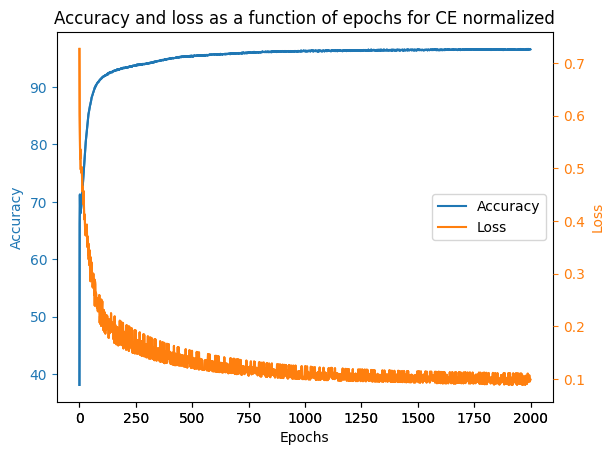

In [42]:
fig=plt.figure()
ax1=fig.add_subplot(111, label='Accuracy')
ax2=fig.add_subplot(111, label='Loss', frame_on=False)

ax1.set_title('Accuracy and loss as a function of epochs for CE normalized')

ax1.plot(NetCE_Acc_train_norm, color="C0")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color="C0")
ax1.tick_params(axis='y', colors="C0")

ax2.plot(NetCE_Loss_train_norm, color="C1") 
ax2.set_ylabel('Loss', color="C1")       
ax2.yaxis.set_label_position('right') 
ax2.yaxis.tick_right()
ax2.tick_params(axis='y', colors="C1")

l1,=ax1.plot(NetCE_Acc_train_norm, color="C0")
l2,=ax2.plot(NetCE_Loss_train_norm, color="C1")
plt.legend([l1, l2], ["Accuracy", "Loss"], loc = "center right")

plt.show()

### Signal and background predictions from training and validation

In [43]:
# Separation of signal and background

NetCE_Pred_train_norm_sig : Sequence = [] # training
NetCE_Pred_train_norm_back : Sequence = []

NetCE_Pred_val_norm_sig : Sequence = [] # validation
NetCE_Pred_val_norm_back : Sequence = []


for i in range(0, len(NetCE_Pred_train_norm)) : # training
    if NetCE_Actual_train_norm[i] == 1 :
        NetCE_Pred_train_norm_sig.append(NetCE_Pred_train_norm[i])
    elif NetCE_Actual_train_norm[i] == 0 :
        NetCE_Pred_train_norm_back.append(NetCE_Pred_train_norm[i])

for i in range(0, len(NetCE_Pred_val_norm)) : # validation
    if NetCE_Actual_val_norm[i] == 1 :
        NetCE_Pred_val_norm_sig.append(NetCE_Pred_val_norm[i])
    elif NetCE_Actual_val_norm[i] == 0 :
        NetCE_Pred_val_norm_back.append(NetCE_Pred_val_norm[i])


NetCE_Pred_train_norm_sig_array = np.array(NetCE_Pred_train_norm_sig) # training
NetCE_Pred_train_norm_back_array = np.array(NetCE_Pred_train_norm_back)

NetCE_Pred_val_norm_sig_array = np.array(NetCE_Pred_val_norm_sig) # validation
NetCE_Pred_val_norm_back_array = np.array(NetCE_Pred_val_norm_back)


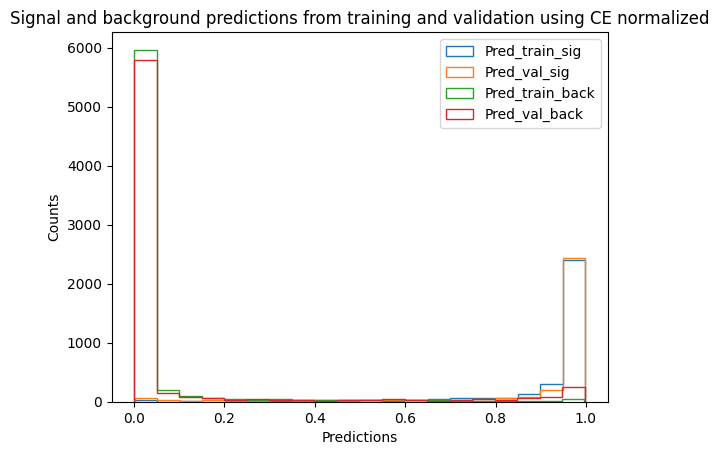

In [44]:
# Signal predictions 

plt.hist(NetCE_Pred_train_norm_sig_array, histtype='step', bins=20, label = 'Pred_train_sig')
plt.hist(NetCE_Pred_val_norm_sig_array, histtype='step', bins=20, label = 'Pred_val_sig')

# Background predictions

plt.hist(NetCE_Pred_train_norm_back_array, histtype='step', bins=20, label = 'Pred_train_back')
plt.hist(NetCE_Pred_val_norm_back_array, histtype='step', bins=20, label = 'Pred_val_back')


plt.title('Signal and background predictions from training and validation using CE normalized')
plt.xlabel("Predictions")
plt.ylabel("Counts")

plt.legend()
plt.show()


# --> validation mieux pour signal mais pas pour background


### Comparison between MSE, CE and CE_norm

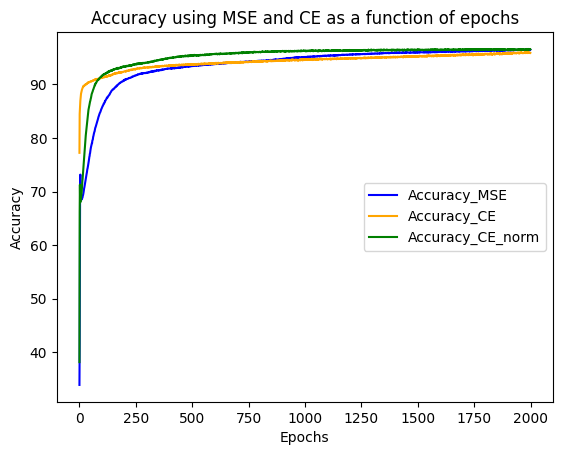

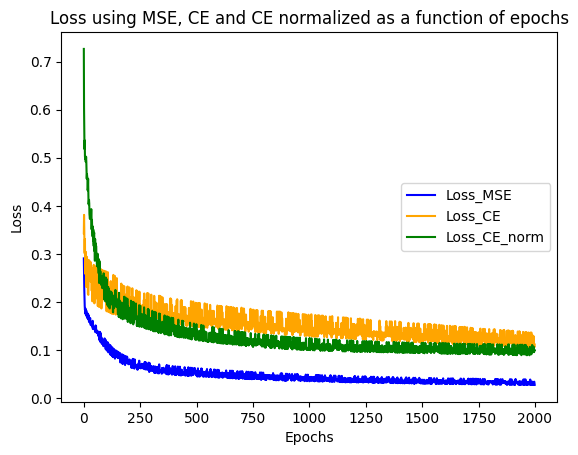

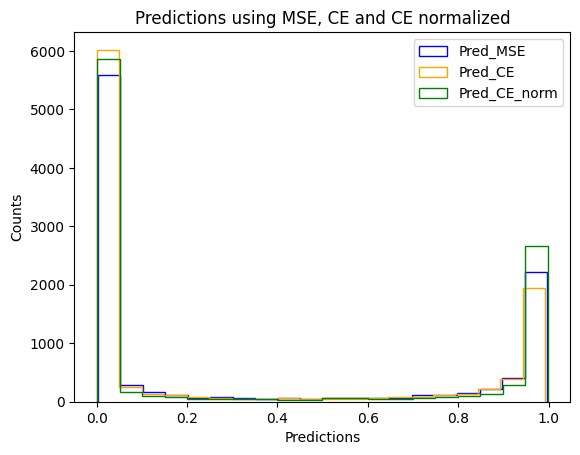

In [45]:
# Training accuracy

plt.plot(NetMSE_Acc_train, label = 'Accuracy_MSE', color = 'blue')
plt.plot(NetCE_Acc_train, label = 'Accuracy_CE', color = 'orange')
plt.plot(NetCE_Acc_train_norm, label = 'Accuracy_CE_norm', color = 'green')

plt.title('Accuracy using MSE and CE as a function of epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend(loc = 'center right')
plt.show()


# Training loss

plt.plot(NetMSE_Loss_train, label = 'Loss_MSE', color = 'blue')
plt.plot(NetCE_Loss_train, label = 'Loss_CE', color = 'orange')
plt.plot(NetCE_Loss_train_norm, label = 'Loss_CE_norm', color = 'green')

plt.title('Loss using MSE, CE and CE normalized as a function of epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc = 'center right')
plt.show()


# Validation predictions

plt.hist(NetMSE_Pred_val, histtype='step', bins=20, label = 'Pred_MSE', color = 'blue')
plt.hist(NetCE_Pred_val, histtype='step', bins=20, label = 'Pred_CE', color = 'orange')
plt.hist(NetCE_Pred_val_norm, histtype='step', bins=20, label = 'Pred_CE_norm', color = 'green')

plt.title('Predictions using MSE, CE and CE normalized')
plt.xlabel("Predictions")
plt.ylabel("Counts")

plt.legend()
plt.show()